In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from torch.utils.data import Dataset
import torch.nn as nn
import torch
import collections
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [5]:
BOX_PATH = "/content/drive/MyDrive/data/valid_bboxes.npy"
IMAGE_PATH = "/content/drive/MyDrive/data/valid_X.npy"
LABEL_PATH = "/content/drive/MyDrive/data/valid_Y.npy"
SEGMENT_PATH = "/content/drive/MyDrive/data/valid_seg.npy"

val_boxes = np.load(BOX_PATH)
val_segments = np.load(SEGMENT_PATH).reshape(5000, 64, 64)
val_images = np.load(IMAGE_PATH)
val_labels = np.load(LABEL_PATH)

In [6]:
for i in range(5000):
  mask_file = str(i) + "_mask.png"
  image_file = str(i) + ".png"
  img = Image.fromarray(val_images[i].reshape((64,64,3)), 'RGB')
  img.save(os.path.join("/content/drive/MyDrive/mnist/segment/valid/image/", image_file))
  img = Image.fromarray(val_segments[i].reshape((64,64)))
  img.save(os.path.join("/content/drive/MyDrive/mnist/segment/valid/mask/", mask_file))

In [7]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms

        self.imgs = list(sorted(os.listdir(os.path.join(root, "image"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "mask"))))

    def __getitem__(self, idx):

        img_path = os.path.join(self.root, "image", self.imgs[idx])
        mask_path = os.path.join(self.root, "mask", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        obj_ids = torch.unique(mask)
        obj_ids = obj_ids[:-1]
        num_objs = len(obj_ids)
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        boxes = masks_to_boxes(masks)

        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [12]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes,
    )

    return model

In [13]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

In [14]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [15]:
from engine import train_one_epoch, evaluate
import utils
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 10
dataset = MNISTDataset('/content/drive/MyDrive/mnist/segment', get_transform(train=True))
dataset_test = MNISTDataset('/content/drive/MyDrive/mnist/segment/valid', get_transform(train=False))

indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)

model = get_model_instance_segmentation(num_classes)

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)
num_epochs = 2

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    lr_scheduler.step()



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:02<00:00, 80.3MB/s]


Epoch: [0]  [   0/2475]  eta: 5:51:42  lr: 0.000010  loss: 4.5940 (4.5940)  loss_classifier: 2.9310 (2.9310)  loss_box_reg: 0.0657 (0.0657)  loss_mask: 1.1850 (1.1850)  loss_objectness: 0.3827 (0.3827)  loss_rpn_box_reg: 0.0297 (0.0297)  time: 8.5263  data: 0.1715  max mem: 1651
Epoch: [0]  [ 100/2475]  eta: 0:18:42  lr: 0.000509  loss: 0.9330 (1.4253)  loss_classifier: 0.1371 (0.5157)  loss_box_reg: 0.1190 (0.0979)  loss_mask: 0.6185 (0.7027)  loss_objectness: 0.0309 (0.0860)  loss_rpn_box_reg: 0.0120 (0.0230)  time: 0.3938  data: 0.0098  max mem: 1820
Epoch: [0]  [ 200/2475]  eta: 0:16:31  lr: 0.001009  loss: 0.9402 (1.1867)  loss_classifier: 0.1473 (0.3342)  loss_box_reg: 0.1533 (0.1248)  loss_mask: 0.5936 (0.6507)  loss_objectness: 0.0217 (0.0600)  loss_rpn_box_reg: 0.0063 (0.0171)  time: 0.4087  data: 0.0087  max mem: 1820
Epoch: [0]  [ 300/2475]  eta: 0:15:34  lr: 0.001508  loss: 1.0562 (1.1292)  loss_classifier: 0.1966 (0.2839)  loss_box_reg: 0.2148 (0.1482)  loss_mask: 0.6217 (

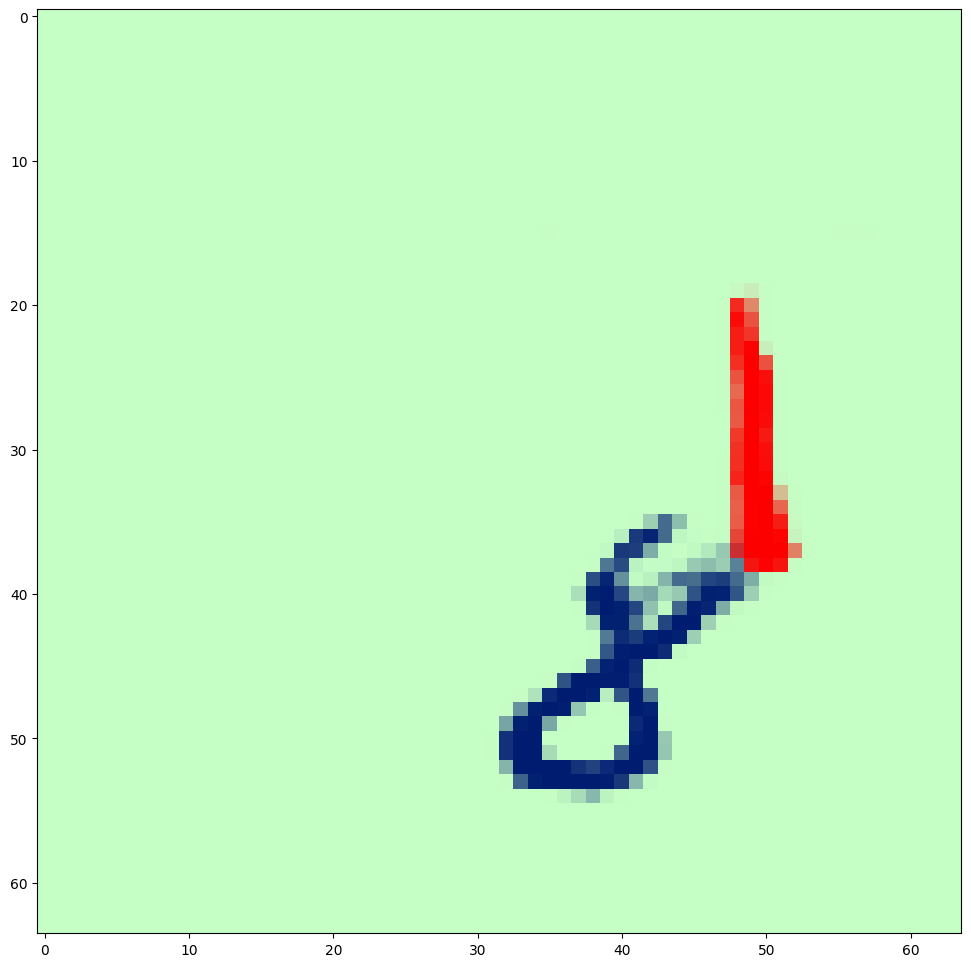

In [16]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

image = read_image("/content/drive/MyDrive/mnist/segment/valid/image/1.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    x = x.to(device)
    predictions = model([x, ])
    pred = predictions[0]

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"{score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]


masks = (pred["masks"] > 0.9).squeeze(1)
output_image = draw_segmentation_masks(image, masks, alpha=0.0, colors="blue")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))